In [58]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [59]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [60]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [62]:
mnist.data.shape

(70000, 784)

In [63]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [64]:
X /= 255.0

In [65]:
X.min(), X.max()

(0.0, 1.0)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [68]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [69]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

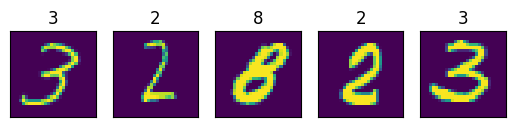

In [70]:
plot_example(X_train, y_train)

In [71]:
from tensorflow import keras

In [72]:
X_train = X_train.reshape([-1, 28, 28, 1]).astype('float32')
X_test = X_test.reshape([-1, 28, 28, 1]).astype('float32')



In [73]:
from keras.utils import to_categorical

Y_train_cm = y_train
Y_test_cm = y_test

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [74]:
vgg = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=((32, 32, 3)),
    pooling=None,
)

In [75]:
X_train = np.pad(X_train, ((0,0), (2,2), (2,2), (0, 0)))
X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2), (0, 0)))

In [76]:
print(X_train.shape)
print(X_test.shape)

(52500, 32, 32, 1)
(17500, 32, 32, 1)


In [77]:
vgg.layers

In [78]:
for layer in vgg.layers:
    layer.trainable = False

In [79]:
vgg.layers

In [80]:
from keras.layers import Activation, Dense, Flatten

d1 = Dense(4096, activation = 'relu')(vgg.layers[-1].output)
d2 = Dense(4096, activation='relu')(d1)
d3 = Dense(4096, activation='relu')(d2)
d4 = Dense(10, activation='softmax')(d3)
d4 = Flatten()(d4)

In [81]:
model = keras.Model(inputs = vgg.inputs, outputs = d4)

In [82]:
model.layers

In [84]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07), metrics=['accuracy'])

In [85]:
print(X_train.shape)
print(Y_train.shape)

print(Y_train[2])

(52500, 32, 32, 1)
(52500, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [86]:
import tensorflow as tf

In [87]:
model.fit(keras.layers.Lambda(tf.image.grayscale_to_rgb)(X_train), Y_train, epochs = 5, batch_size = 32)

Epoch 1/5
1641/1641 [==============================] - 35s 21ms/step - loss: 0.3342 - accuracy: 0.8916
Epoch 2/5
1641/1641 [==============================] - 34s 21ms/step - loss: 0.1925 - accuracy: 0.9408
Epoch 3/5
1641/1641 [==============================] - 33s 20ms/step - loss: 0.1579 - accuracy: 0.9510
Epoch 4/5
1641/1641 [==============================] - 34s 21ms/step - loss: 0.1389 - accuracy: 0.9555
Epoch 5/5
1641/1641 [==============================] - 34s 20ms/step - loss: 0.1230 - accuracy: 0.9605


In [88]:
eval = model.evaluate(keras.layers.Lambda(tf.image.grayscale_to_rgb)(X_test), Y_test, batch_size = 32)

547/547 [==============================] - 6s 10ms/step - loss: 0.1417 - accuracy: 0.9583


In [33]:
test = X_test[0:5, :,:,:]

In [89]:
predictions = model.predict(keras.layers.Lambda(tf.image.grayscale_to_rgb)(test))

1/1 [==============================] - 1s 981ms/step


In [90]:
print(predictions)

[[4.1397172e-07 8.8440764e-08 3.5746695e-04 8.7510325e-06 2.9045454e-04
  5.4404995e-06 1.6517562e-06 1.3120234e-06 9.9912256e-01 2.1187034e-04]
 [2.8259972e-08 7.1191589e-06 7.1515533e-05 3.9468327e-06 9.9445480e-01
  4.8568263e-06 1.1337279e-06 4.1699847e-03 1.2405235e-03 4.6121528e-05]
 [3.1351483e-08 9.3265973e-10 4.0923034e-05 3.7156553e-07 3.4729879e-08
  1.2037145e-07 7.2677506e-07 7.6653517e-11 9.9995756e-01 2.0061957e-07]
 [1.2339441e-14 3.4697671e-08 5.3716280e-07 4.3260121e-07 6.1019373e-10
  5.2837470e-07 6.9226032e-19 9.9999857e-01 4.2331588e-10 6.4654915e-10]
 [2.8466764e-07 1.9186925e-03 1.1584655e-04 3.4526750e-04 1.4868518e-03
  2.3911020e-04 9.9054223e-09 9.9455017e-01 8.1162128e-05 1.2625500e-03]]


In [91]:
one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), predictions.argmax(axis=1)] = 1

print("One-hot predictions:")
print(one_hot_predictions)

One-hot predictions:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_labels(X_padded, Y, num_images=5):
    """
    Plot the first 'num_images' images from X_padded (padded images) along with their corresponding labels from Y.
    Unpads the images to original shape (batch_size, 28, 28, 1) before plotting.

    Parameters:
    - X_padded: numpy array of shape (batch_size, 32, 32, 1) containing padded images
    - Y: numpy array of shape (batch_size, 10) containing one-hot encoded labels
    - num_images: number of images to plot (default is 5)
    """
    # Unpad the images to original shape (batch_size, 28, 28, 1)
    X = X_padded[:, 2:-2, 2:-2, :]

    # Extract the first 'num_images' images and their corresponding labels
    X_subset = X[:num_images]
    Y_subset = Y[:num_images]

    # Plot the images and labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Plot image
        axes[i].imshow(X_subset[i, :, :, 0], cmap='gray')
        axes[i].axis('off')

        # Set title with label information
        label = np.argmax(Y_subset[i])
        axes[i].set_title(f'Label: {label}')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming X_padded and Y are defined as your datasets with correct shapes
# plot_images_with_labels(X_padded, Y, num_images=5)


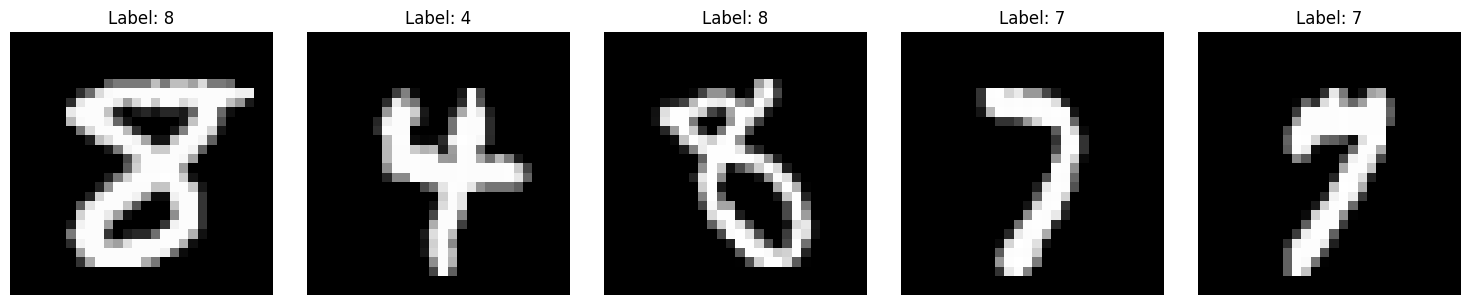

In [93]:
plot_images_with_labels(test, one_hot_predictions)